In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

import seaborn as sns


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip /content/drive/MyDrive/Garbage_classification.zip

Archive:  /content/drive/MyDrive/Garbage_classification.zip
   creating: Garbage classification/
   creating: Garbage classification/cardboard/
  inflating: Garbage classification/cardboard/cardboard1.jpg  
  inflating: Garbage classification/cardboard/cardboard10.jpg  
  inflating: Garbage classification/cardboard/cardboard100.jpg  
  inflating: Garbage classification/cardboard/cardboard101.jpg  
  inflating: Garbage classification/cardboard/cardboard102.jpg  
  inflating: Garbage classification/cardboard/cardboard103.jpg  
  inflating: Garbage classification/cardboard/cardboard104.jpg  
  inflating: Garbage classification/cardboard/cardboard105.jpg  
  inflating: Garbage classification/cardboard/cardboard106.jpg  
  inflating: Garbage classification/cardboard/cardboard107.jpg  
  inflating: Garbage classification/cardboard/cardboard108.jpg  
  inflating: Garbage classification/cardboard/cardboard109.jpg  
  inflating: Garbage classification/cardboard/cardboard11.jpg  
  inflating: Ga

In [7]:
train_dir  = '/content/Garbage classification'

classes = os.listdir(train_dir)
print(classes)


['paper', 'trash', 'metal', 'glass', 'cardboard', 'plastic']


In [2]:
# train_dir = "../input/garbage-classification/Garbage classification/Garbage classification"

In [8]:
tf.test.is_gpu_available()

True

Performing data augmentation and scaling

In [9]:
# implementing on the fly data augmentation using ImageDataGetnerator
train_generator = ImageDataGenerator(rotation_range= 90,
                              rescale= 1.0/255,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              validation_split = 0.2)

training_data = train_generator.flow_from_directory(train_dir,
                                             batch_size=16,
                                             class_mode = "categorical",
                                             subset = 'training')

validation_data = train_generator.flow_from_directory(train_dir,
                                             batch_size=16,
                                             class_mode = "categorical",
                                             subset = 'validation')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


Print some of the images to have a look

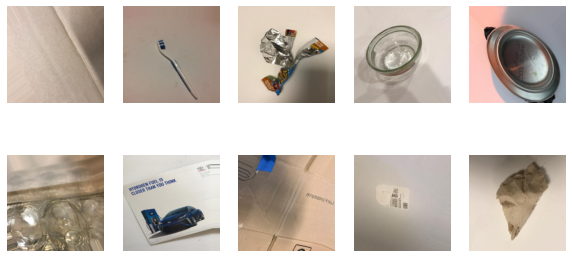

In [10]:
plt.figure(figsize=(10, 5))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, _ in training_data:
        image = X_batch[0]
        plt.axis('off')
        plt.imshow(image)
        break


Importing keras mobileNetV2 model to fine tune on.

In [11]:
img_size = training_data[0][0].shape[1]
img_shape = (img_size, img_size, 3)

# Create the base pretrained model
base = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                        include_top=False,
                                        weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
# Changing the pretrained model weights when training
base.trainable = True
# Note: I tried to set trainable to false.

# Getting the vector the connects the convolutional layers to the final fully connected layers 
# using global average pooling
global_avg = tf.keras.layers.GlobalAveragePooling2D()

# The prediction layer for our dataset
pred_layer = tf.keras.layers.Dense(6, activation='softmax')

In [13]:
model = tf.keras.Sequential([
    base,
    global_avg,
    pred_layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


The difference when it came to training with trainable true. the new layer was completely random while the first layers were not. so it was very overfitting.

In [14]:
history = model.fit(training_data, epochs=17, validation_data = validation_data, verbose = 1)

Epoch 1/17
127/127 [==============================] - 58s 348ms/step - loss: 0.8656 - acc: 0.6868 - val_loss: 1.4249 - val_acc: 0.4732
Epoch 2/17
127/127 [==============================] - 43s 341ms/step - loss: 0.4403 - acc: 0.8562 - val_loss: 1.1966 - val_acc: 0.5686
Epoch 3/17
127/127 [==============================] - 42s 332ms/step - loss: 0.3486 - acc: 0.8790 - val_loss: 0.9939 - val_acc: 0.6402
Epoch 4/17
127/127 [==============================] - 42s 333ms/step - loss: 0.2520 - acc: 0.9160 - val_loss: 1.5787 - val_acc: 0.4871
Epoch 5/17
127/127 [==============================] - 43s 342ms/step - loss: 0.2155 - acc: 0.9229 - val_loss: 1.1634 - val_acc: 0.6322
Epoch 6/17
127/127 [==============================] - 42s 333ms/step - loss: 0.1822 - acc: 0.9392 - val_loss: 0.9130 - val_acc: 0.7078
Epoch 7/17
127/127 [==============================] - 42s 333ms/step - loss: 0.1649 - acc: 0.9476 - val_loss: 1.2032 - val_acc: 0.6481
Epoch 8/17
127/127 [==============================] - 4

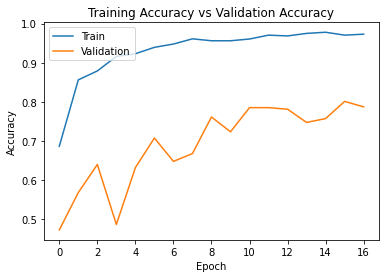

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Here we can see that the validation is lacking behind. Maybe that happened because the new added layer is completely random while the pretrained model was already trained. So, the the new layer was heavily biased towards the training data. To test that we will create another model but make the base model not trainable. The hypothesis is that in that case the train and validation curves would be closer together but the accuracy might be lower.

In [16]:
base2 = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                        include_top=False,
                                        weights='imagenet')

# Not changing the pretrained model weights when training
base2.trainable = False

# Getting the vector the connects the convolutional layers to the final fully connected layers 
# using global average pooling
global_avg2 = tf.keras.layers.GlobalAveragePooling2D()

# The prediction layer for our dataset
pred_layer2 = tf.keras.layers.Dense(6, activation='softmax')

model2 = tf.keras.Sequential([
    base2,
    global_avg2,
    pred_layer2
])

model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])

As expected the accuracy is closer to validation with lower accuracy.

**Saving the weights of the best model**

In [17]:
model.save('myModel.h5')